# Time Series Analysis and Fourier Methods


## ROSES Tutorial Outline

1. Some initial intuition on the FFT
2. Computing the PSD (or amplitude spectrum)
3. Good Practices to dealing with Fourier transforms
## Expected for you to do
4. Noise Spectra
5. Cross-Correlation
6. Deconvolution
7. Spectral Ratios

### Instructor: Germán A. Prieto (gaprietogo@unal.edu.co)

We spent some time reviewing some of the basics of the Fourier Transform and how that applies to finite length and discretely sampled data using the DFT.

Let's start with some basic intuition and learning how most algorithms of the FFT store the data once the FFT is computed. As we have seen in previous lectures, Obspy and probably other seismology packages will be able to do some of this stuff with a single command (compute the PSD, do cross-correlations, etc.), but in many cases, if you want to work with large amounts of data or do something different, you will probably have to implement the codes yourself. 

And it is fun to do it yourself anyways. Just don't reinvent the wheel (the FFT has been around for at least 60 years) so don't need to write the FFT yourself. 


#### Import basic packages that we will use. 

In [4]:
import numpy as np
import scipy
import scipy.signal as signal
import matplotlib.pyplot as plt
import obspy
from obspy.clients.fdsn import Client

## Basic example of the FFT

As you might recall, the FT of a real signal, is symmetric $\hat{f}(\nu)=\hat{f}(-\nu)$.

Let's get two real-valued random sequences, with 10 and 11 points, zero-mean and $\sigma=0.5$.

In [2]:
nx = 10
ny = 11
x = np.random.normal(0.0,0.5,(nx,1))
y = np.random.normal(0.0,0.5,(ny,1))
print(x)
print('')
print(y)

[[ 0.4358265 ]
 [ 0.15917783]
 [ 0.40839107]
 [ 0.559568  ]
 [ 0.5329567 ]
 [-0.42254204]
 [-0.76088651]
 [ 0.1476025 ]
 [-0.43865156]
 [-0.09704144]]

[[ 0.34287533]
 [-0.06665487]
 [ 0.07668794]
 [ 0.41350465]
 [ 0.00888212]
 [ 0.27280307]
 [ 0.01824188]
 [ 0.4719906 ]
 [ 0.54557189]
 [ 0.07165114]
 [ 0.09849388]]


#### Compute the FFT of each sequence.

Notice the symmetry of the transformed data. Also, how the first point ($\nu=0$ Hz) is real, while the rest is complex.

Notice also the difference between the FFT of an even sequence ($x$) and an odd sequence ($y$). 

In [1]:
fx = ...
fy = ...
print(fx)
print('')
print(fy)

Ellipsis

Ellipsis


Scipy, and in general the FFTW algorithm, have a version of the FFT for a real sequence, 
that returns the transform only with the unique number of Fourier coefficients needed to describe the signal. 

For $nx$ even, the number of frequency points is $nf=(nx/2)+1$, that is $nx=10$, $nf=6$

For $ny$ odd,  the number of frequency points is $nf=(nx+1)/2$, that is $ny=11$, $nf=6$


If you are dealing with a complex time series, or if you want to do correlations, coherence, deconvolution, you need to keep the entire fourier transform. I recommend to use the `scipy.fft.fft` and just keep in mind $nf$ if you want to plot the PSD. 

In [4]:
# The rfft version
fx = ...
fy = ...
print(fx)
print(fy)

[[ 0.52440107+0.j        ]
 [ 0.86515832-2.10849176j]
 [-0.58558023+0.73110709j]
 [ 1.36532735-0.73417061j]
 [ 0.35659086+1.02368298j]
 [-0.16912864+0.j        ]]
[[ 2.25404764+0.j        ]
 [-0.29936878+0.49370335j]
 [-0.48485965-0.21155815j]
 [ 0.80837062+0.10274504j]
 [ 0.76725134+0.56322732j]
 [-0.03260304-0.52416778j]]


#### What frequency is represented for the FFT

We did not discuss this in the lecture part, but `scipy` (as well as `numpy`) have functions to help you with that.

The Nyquist frequency in our example with $dt=1.0 s$, is $f_{nyq}=0.5=1/dt$. 

Note that the frequency array is slightly different, even though $nf$ is the same for both. 

In [5]:
# Define corresponding frequency vector
freqx = ...
freqy = ...
print(freqx)
print(freqy)

[ 0.   0.1  0.2  0.3  0.4 -0.5 -0.4 -0.3 -0.2 -0.1]
[ 0.          0.09090909  0.18181818  0.27272727  0.36363636  0.45454545
 -0.45454545 -0.36363636 -0.27272727 -0.18181818 -0.09090909]


In [6]:
# Freq vector for a long time series
freq_long = scipy.fft.fftfreq(100*nx)
print(freq_long[0:3])

[0.    0.001 0.002]


#### Key things to remember

The FFT algorithm (as implemented) displays first the positive frequencies, and then the negative frequencies.

Scipy puts the Nyquist frequency as a negative frequency (don't know why???).

If the number of points of the time series $nx$ is greater, the frequency sampling $df$ is smaller. **Be careful, smaller frequency sampling, does not mean higher resolution** for example when applying zero-padding.   

## Example 1. A synthetic example

The toy signal has a fundamental frequency (that WE NEED to determine), inmersed in a background colored-spectra.
The toy signal really has 10 *realizations*, in the code below one of the *realizations* is randomly selected.

**To avoid complications in explaining the codes, I normalize the spectrum in a quick way (could be better). One should always do it**

$$ var(x) = \int_{-1/2}^{1/2} S(f) df = \sum_{n=0}^{nfft} S(f) * df$$

You should have access to the data ``test1.dat`` thru Slack.

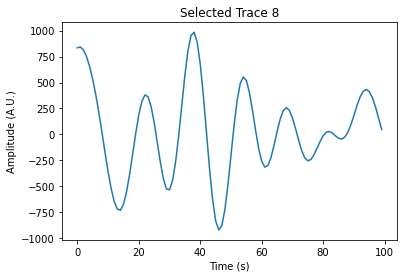

In [22]:
# Load data. 
x       = np.loadtxt('test1.dat')
npts    = np.size(x,0)
ntr     = np.size(x,1)
dt      = 1.0  # 1 sps
t       = np.arange(0,npts)*dt

# randomly select one trace
itr     = np.random.randint(0,ntr)
x2      = x[:,itr]
xvar    = np.var(x2)

# Plot time series
fig = plt.figure()
ax  = fig.add_subplot(111)
ax.plot(t,x2)
ax.set_title('Selected Trace '+str(itr));
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude (A.U.)');

**Calculate Periodogram (with box car taper)**

You should never really do this, but just so you know, this is how one would do it. 

In [21]:
#---------------------------------------
# Check if data is even or odd, define nf
#---------------------------------------
...nf

#---------------------------------------
# Get frequency vector
#---------------------------------------
...freq

#---------------------------------------
# calculate Periodogram (***** bad idea, never do *****)
#---------------------------------------
...Sp

fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(freq,Sp)
ax.set_title('Trace = '+str(itr))
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('$A^2/$Hz');

SyntaxError: invalid syntax (<ipython-input-21-1a9c05f90050>, line 4)

**Calculate tapered periodogram (with a hanning taper, or other)**

In this case I will use a Hanning taper, but you could easily apply other tapers, including
the prolate tapers (used in the multitaper algorithm). 
for example ``dpss,v = signal.windows.dpss(nwin, tbp, Kmax=kspec, return_ratios=True)``

In [20]:
#---------------------------------------
# Calculate hanning, and taper series
#---------------------------------------
hann = np.hanning(npts)
xhan = x2*hann

#---------------------------------------
# PSD and normalize
#---------------------------------------
Sh   = scipy.fft.fft(xhan,npts)
Sh   = abs(Sh)**2
Ssc  = xvar/(np.sum(Sh)*df)
Sh   = Sh*Ssc
Sh   = 2*Sh[0:nf]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(freq,Sp)
ax.semilogy(freq,Sh)
ax.set_title('Trace = '+str(itr));
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('$A^2/$Hz');

NameError: name 'df' is not defined

## Notes

Here it is clear why _spectral leakage_ is a real problem. You need to avoid using the raw periodogram. 

**Good Practice**
- Detrend the signal (or at least demean the signal).
- Always use a taper.
- Zero padding is a good idea. But pad after tapering, not before. 
- Always (done roughly here) normalize your power spectrum, to get the right units. The integral of the PSD is equal to the variance of the time series.  
- Amplitude spectrum = $\sqrt{S(f)*T}$, where $T$ is the length of the time series in seconds. 
- Spectra units 
    - PSD - $units^2/Hz$
    - Amplitude spectrum $units/Hz=units.s$. 


## Example 3. Seismology example - Normal modes for Sumatra Earthquake

The Sumatran earthquake of December 2004, excited many of the normal modes of the Earth. The modes of our planet are of the order of $m$Hz, with examples 
- $_0S_0$, having a frequency 0.81 $m$Hz, period of about 20 min.
- $_0S_4$, having a frequency 0.62 $m$Hz, period of about 26 min.
- $_0S_3$, having a frequency 0.47 $m$Hz, period of about 37 min.

You should have access to the data ``sumatra.mseed`` thru Slack, but if not, just remove comments to download the data. 

1 Trace(s) in Stream:
IU.ANMO.00.LHZ | 2004-12-26T00:00:00.485600Z - 2004-12-29T23:59:59.485600Z | 1.0 Hz, 345600 samples


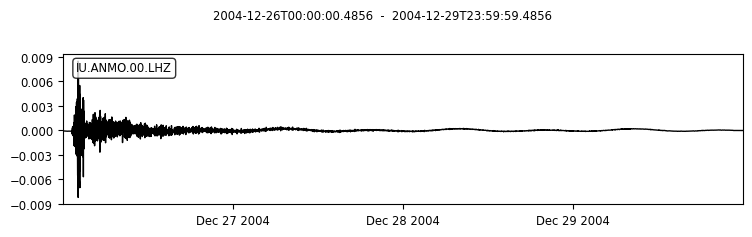

In [10]:
# SDownload data from IRIS (only if you need to)
#client = Client("IRIS")
#t1 = obspy.UTCDateTime("2004-12-26")
#starttime = t1
#endtime = t1 + 4*24*60*60  # 4 days of data
#net = "IU"
#sta = "ANMO"
#loc = "00"
#chan = "LHZ"
#st = client.get_waveforms(net, sta, loc, chan, starttime, endtime, attach_response = True)
#st.remove_response(output = 'DISP')
#st = st.write("sumatra.mseed", format="MSEED")  

st = obspy.read('sumatra.mseed')

print(st)
st.plot()


## Note

We will try to do all our calculations ourselves, not with the default from Obspy. Pull out the data and info needed.

**Here we will pad with zeros to double the length of the signal**. This does not improve the resolution of the FFT, but avoids the cycling issue of the FFT. This is especially important for correlations, deconvolution, etc. 

In [11]:
#-------------------------------------------
# Get the data, npts, and padd ing length
#-------------------------------------------

tr    = st[0]
data  = tr.data
dt    = tr.stats.delta
npts  = tr.stats.npts
npts2 = 2*npts
nf    = int(npts2/2 + 1)


345600 691200 345601


In [6]:
x3    = signal.detrend(data,type='constant')
xvar3 = np.var(x3)
Tall  = dt*npts2   # the length of the series

#---------------------------------------------------------------
# Calculate hanning PSD, pad to twice the length
#---------------------------------------------------------------
hann= np.hanning(npts)
...Px3

#---------------------------------------
# Get amplitude spectrum
#---------------------------------------
...Ax3 

#---------------------------------------
# Frequency vector
#---------------------------------------
freq3 = scipy.fft.fftfreq(npts2,dt)
freq3 = freq3[0:nf]

fig = plt.figure()
ax = fig.add_subplot(211)
ax.plot(freq3*1000,Ax3)
ax.set_xlim(0.2 , 1)
ax.set_xlabel('Frequency (mHz)')
ax.set_ylabel('Amplitude (m/Hz)')
...

SyntaxError: invalid syntax (<ipython-input-6-e99c4359aa77>, line 9)

# $\color{red}{\text{Homework Lab starts here}}$